In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import kagglehub
path = kagglehub.dataset_download("hijest/englishrussian-dictionary-for-machine-translate")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'englishrussian-dictionary-for-machine-translate' dataset.
Path to dataset files: /kaggle/input/englishrussian-dictionary-for-machine-translate


In [3]:
import string
import re
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import pandas as pd

# Путь к вашему файлу
text = "/kaggle/input/englishrussian-dictionary-for-machine-translate/rus.txt"

# Чтение файла и обработка строк
with open(text, encoding='utf-8') as file:
    lines = file.read().split("\n")

pairs = []

for line in lines:
    # Ищем разделитель табуляции
    parts = line.split("\t")
    if len(parts) >= 2:
        english, russian = parts[0], parts[1]
        # Добавляем специальные токены для начала и конца предложения
        russian = "[start] " + russian + " [end]"
        pairs.append((english, russian))

In [4]:
df = pd.DataFrame(pairs)
df.head(20)

,0,1
0,Go.,[start] Марш! [end]
1,Go.,[start] Иди. [end]
2,Go.,[start] Идите. [end]
3,Hi.,[start] Здравствуйте. [end]
4,Hi.,[start] Привет! [end]
5,Hi.,[start] Хай. [end]
6,Hi.,[start] Здрасте. [end]
7,Hi.,[start] Здоро́во! [end]
8,Run!,[start] Беги! [end]
9,Run!,[start] Бегите! [end]


In [5]:
import random
print(random.choice(pairs))
print(len(pairs))

('I could help you with that.', '[start] Я мог бы тебе с этим помочь. [end]')
363386


In [6]:
random.shuffle(pairs)
num_val_samples = int(0.2 * len(pairs))
num_train_samples = len(pairs) - 2 * num_val_samples
train_pairs = pairs[:num_train_samples]
val_pairs = pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = pairs[num_train_samples + num_val_samples:]

In [7]:
print(len(train_pairs))
print(len(val_pairs))
print(len(test_pairs))

218032
72677
72677


In [8]:
strip_chars = string.punctuation + "." + "," + "?" + "!"

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [9]:
custom_standardization(pairs)

<tf.Tensor: shape=(363386, 2), dtype=string, numpy=
array([[b'tom didnt want to continue the conversation',
        b'start \xd0\xa2\xd0\xbe\xd0\xbc \xd0\xbd\xd0\xb5 \xd1\x85\xd0\xbe\xd1\x82\xd0\xb5\xd0\xbb \xd0\xbf\xd1\x80\xd0\xbe\xd0\xb4\xd0\xbe\xd0\xbb\xd0\xb6\xd0\xb0\xd1\x82\xd1\x8c \xd1\x80\xd0\xb0\xd0\xb7\xd0\xb3\xd0\xbe\xd0\xb2\xd0\xbe\xd1\x80 end'],
       [b'youre irresistible',
        b'start \xd0\x92\xd1\x8b \xd0\xbd\xd0\xb5\xd0\xbe\xd1\x82\xd1\x80\xd0\xb0\xd0\xb7\xd0\xb8\xd0\xbc\xd1\x8b end'],
       [b'everyone in the class likes tom',
        b'start \xd0\x92\xd1\x81\xd0\xb5\xd0\xbc \xd0\xb2 \xd0\xba\xd0\xbb\xd0\xb0\xd1\x81\xd1\x81\xd0\xb5 \xd0\xbd\xd1\x80\xd0\xb0\xd0\xb2\xd0\xb8\xd1\x82\xd1\x81\xd1\x8f \xd0\xa2\xd0\xbe\xd0\xbc end'],
       ...,
       [b'tom was like a brother to mary',
        b'start \xd0\xa2\xd0\xbe\xd0\xbc \xd0\xb1\xd1\x8b\xd0\xbb \xd0\x9c\xd1\x8d\xd1\x80\xd0\xb8 \xd0\xba\xd0\xb0\xd0\xba \xd0\xb1\xd1\x80\xd0\xb0\xd1\x82 end'],
       [b'is there a 

In [10]:
from keras import layers
vocab_size = 30000
sequence_length = 30 #было 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_russian_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_russian_texts)

In [11]:
batch_size = 64

def format_dataset(eng,rus):
    eng = source_vectorization(eng)
    rus = target_vectorization(rus)
    return ({
        "english": eng,
        "russian": rus[:, :-1],
    }, rus[:, 1:])

In [12]:
def make_dataset(pairs):
    eng_texts, rus_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    rus_texts = list(rus_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, rus_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [13]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['russian'].shape: {inputs['russian'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 30)
inputs['russian'].shape: (64, 30)
targets.shape: (64, 30)


In [14]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [15]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [16]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [17]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="russian")

x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)

decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

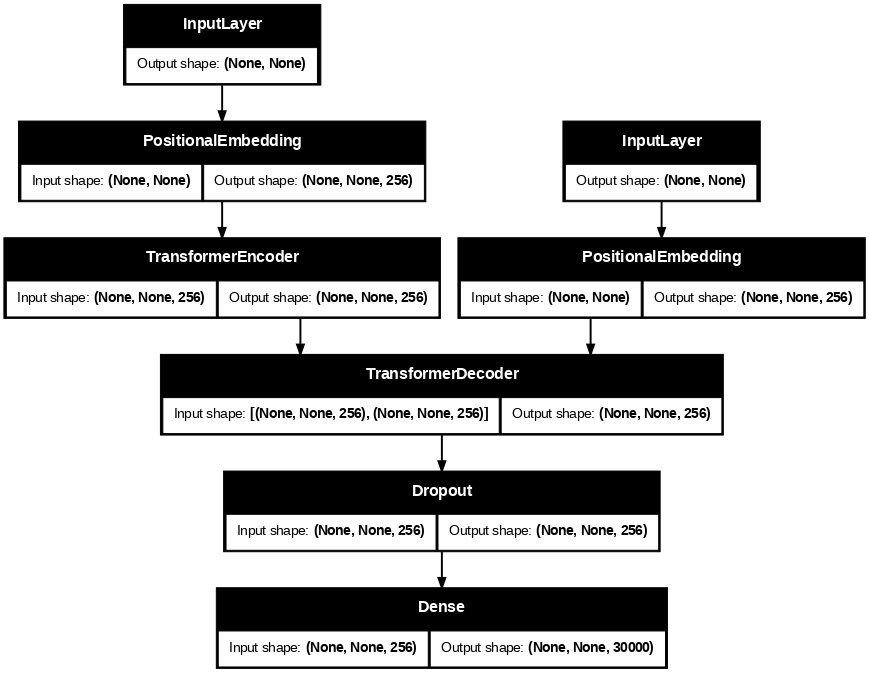

In [18]:
plot_model(model, show_shapes=True, dpi=70)

In [19]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 476s 134ms/step - accuracy: 0.8529 - loss: 1.2507 - val_accuracy: 0.9114 - val_loss: 0.5679
Epoch 2/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 437s 128ms/step - accuracy: 0.9092 - loss: 0.5898 - val_accuracy: 0.9235 - val_loss: 0.4590
Epoch 3/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 440s 129ms/step - accuracy: 0.9199 - loss: 0.4930 - val_accuracy: 0.9283 - val_loss: 0.4239
Epoch 4/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 441s 129ms/step - accuracy: 0.9255 - loss: 0.4515 - val_accuracy: 0.9305 - val_loss: 0.4109
Epoch 5/5
3407/3407 ━━━━━━━━━━━━━━━━━━━━ 441s 129ms/step - accuracy: 0.9289 - loss: 0.4265 - val_accuracy: 0.9317 - val_loss: 0.4035


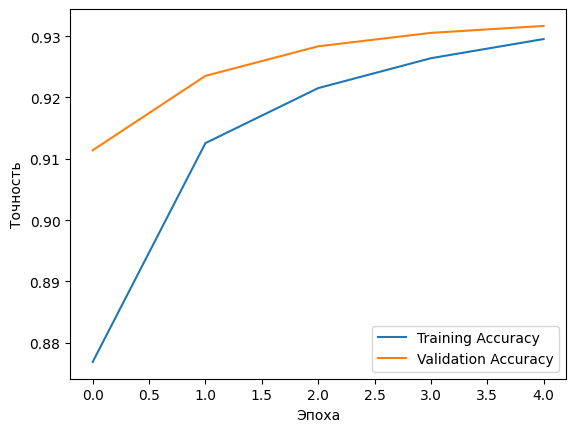

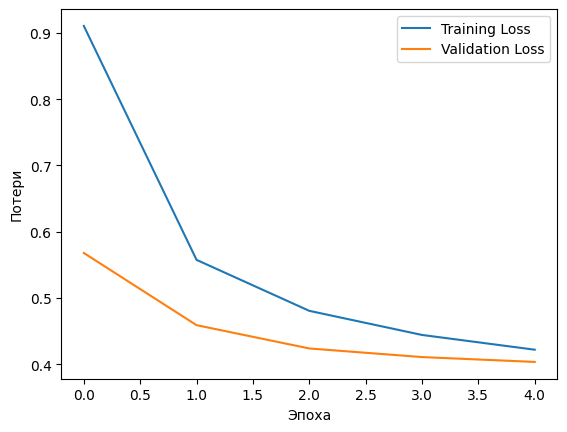

In [20]:
import matplotlib.pyplot as plt
# Построение графика точности
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

# Построение графика потерь
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.show()

In [30]:
import numpy as np
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 30 #было 20

# Функция транслита
def simple_translit(word):
    translit_map = {
        'a':'а','b':'б','v':'в','g':'г','d':'д','e':'е','yo':'ё',
        'zh':'ж','z':'з','i':'и','j':'й','k':'к','l':'л','m':'м',
        'n':'н','o':'о','p':'п','r':'р','s':'с','t':'т','u':'у',
        'f':'ф','h':'х','ts':'ц','ch':'ч','sh':'ш','shch':'щ','y':'ы',
        'ye':'е','yu':'ю','ya':'я'
    }
    return ''.join([translit_map.get(ch, ch) for ch in word])

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = model([tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]

        if sampled_token == "[end]":
            break

        if sampled_token == "[UNK]":
            # Взять последнее слово из входного предложения для транслита
            last_word = input_sentence.split()[-1]
            translit_word = simple_translit(last_word)
            decoded_sentence += " " + translit_word
        else:
            decoded_sentence += " " + sampled_token
    return decoded_sentence

In [37]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Tom wants to know when you're coming.
[start] Том хочет знать когда вы придёте end                       
-
Do you have any objections?
[start] У вас есть какиенибудь какиенибудь обйеcтионс? end                       
-
I always wear a tie to work.
[start] Я всегда ношу галстук на работу end                       
-
Is Tom already asleep?
[start] Том уже спит end                          
-
That's not your job.
[start] Это не твоя работа end                         
-
Let's have a go at it.
[start] Давайте будем в этом пойти end                        
-
You're not the only one who feels that way.
[start] Ты не единственный кто такой такой образом end                      
-
They put the blame on me.
[start] Они меня ме. за меня end                        
-
Tom and Mary say that John is a good cook.
[start] Том и Мэри говорят что Джон хорошо готовит end                     
-
Tom parked behind Mary's car.
[start] Том припарковал за машиной Мэри end                        


In [38]:
def translate(text):
    print(text)
    print(decode_sequence(text))
translate("i like my cat")
translate("do you want sleep")
translate("my computer too old to start this game")

i like my cat
[start] Мне нравится моя кошка end                         
do you want sleep
[start] Ты хочешь спать end                          
my computer too old to start this game
[start] Мой компьютер слишком стар чтобы начать эту игру end                     


In [ ]:
model.save("/content/model1.h5")
# Сохраняем векторизаторы
import pickle
with open('/content/source_vectorization1.pkl', 'wb') as f:
    pickle.dump(source_vectorization, f)
with open('/content/target_vectorization1.pkl', 'wb') as f:
    pickle.dump(target_vectorization, f)
#другой вариант
import joblib
joblib.dump(source_vectorization, 'source_vectorization1.joblib')
joblib.dump(target_vectorization, 'target_vectorization1.joblib')